In [1]:
%load_ext autoreload
%autoreload 2
import numpy
from matplotlib import pyplot
import sys
sys.path.append('../../timeseries/')
sys.path.append('../../src/')
import factors
import observation_models
import state_models
import timeseries_data
from ssm_em import StateSpaceEM
from scipy.stats import zscore

In [44]:
def run_experiment(data_df, whiten: bool=False, train_ratio: float=.5, model_params: dict={'Dz': 2, 'Du': 2}, init_with_pca: bool=False):
    if whiten:
        X = zscore(data_df.to_numpy())
    else:
        X = data_df.to_numpy()
    
    train_length = int(X.shape[0] * train_ratio)
    X_train = X[:train_length]
    X_test = X[train_length:]
    Dx = X_train.shape[1]
    Dz, Du = model_params['Dz'], model_params['Du']
    ##### Run linear model #####
    print('Fitting linear model')
    sm_lin = state_models.LinearStateModel(Dz)
    om_lin = observation_models.LinearObservationModel(Dx, Dz)
    if init_with_pca:
        om_lin.pca_init(X_train)
    linear_model = StateSpaceEM(X_train, observation_model=om_lin, state_model=sm_lin)
    linear_model.run()
    ##### Run heteroscedastic model #####
    print('Fitting heteroscedastic model')
    sm_hs = state_models.LinearStateModel(Dz)
    om_hs = observation_models.HCCovObservationModel(Dx, Dz, Du)
    if init_with_pca:
        om_hs.pca_init(X_train)
    hs_model = StateSpaceEM(X_train, observation_model=om_hs, state_model=sm_hs)
    hs_model.run()
    return linear_model, hs_model, X_train, X_test
    
    
def eval_model(X, model):
    llk = model.compute_predictive_log_likelihood(X)
    predictions = model.predict(X, smoothed=True)
    return llk, predictions

def plot_prediction(X, model, figsize: tuple=None, var_names: list=None):
    data_density = model.compute_predictive_density(X)
    mu = data_density.mu
    std = data_density.Sigma.diagonal(axis1=-2, axis2=-1)
    upper = mu + 1.68 * std
    lower = mu - 1.68 * std
    num_steps, num_vars = X.shape
    if var_names is None:
        var_names = ['x_%d' %i for i in range(num_vars)]
    fig = pyplot.figure(figsize=figsize)
    for iplot in range(num_vars):
        ax = fig.add_subplot(num_vars, 1, iplot+1)
        ax.plot(X[:,iplot], 'C%d' %iplot)
        ax.fill_between(range(num_steps), upper[:,iplot], lower[:,iplot], color='k', alpha=.5, lw=0, zorder=9)
        ax.set_ylabel(var_names[iplot])
        if iplot < num_vars - 1:
            ax.set_xticks([])
        else:
            ax.set_xlabel('timesteps')
    fig.tight_layout()
    return fig

def plot_performance(X, models: list, model_names: list=None, figsize: tuple=None):
    num_models = len(models)
    if model_names is None:
        model_names = ['model %d' %(i+1) for i in range(num_models)]
    
    fig = pyplot.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    for imodel, model in enumerate(models):
        test_llk = eval_model(X, model)[0]
        ax.bar([imodel], [test_llk])
    ax.set_ylabel('log likelihood')
    ax.set_xticks(range(num_models))
    ax.set_xticklabels(model_names, rotation=45)
    return fig

# Synthetic dataset

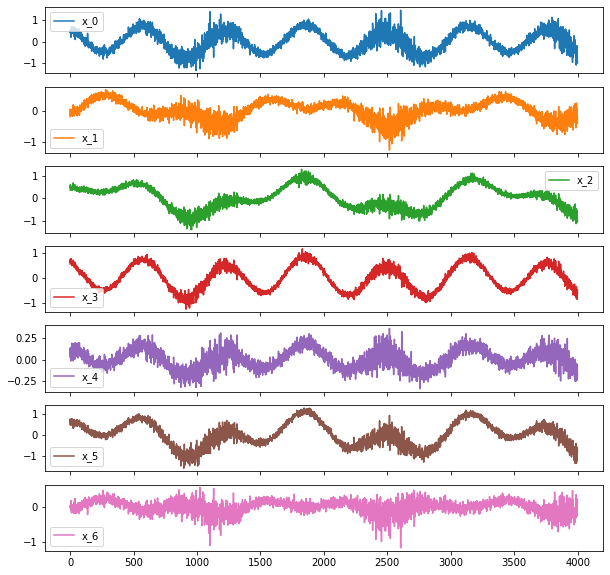

In [64]:
data_df = timeseries_data.load_synthetic_data()
data_df.plot(subplots=True, figsize=(10,10))
pyplot.show()

In [55]:
model_params = {'Dz': 3, 'Du': 6}
linear_model, hs_model, X_train, X_test = run_experiment(data_df, model_params=model_params, whiten=True, init_with_pca=True)

Fitting linear model
Iteration 2 - llk=-1946.2
Iteration 4 - llk=1944.2
Iteration 6 - llk=5322.3
Iteration 8 - llk=7478.8
Iteration 10 - llk=8441.3
Iteration 12 - llk=8778.2
Iteration 14 - llk=8916.9
Iteration 16 - llk=9003.7
Iteration 18 - llk=9065.9
Iteration 20 - llk=9111.1
Iteration 22 - llk=9143.8
Iteration 24 - llk=9167.3
Iteration 26 - llk=9184.1
Iteration 28 - llk=9196.0
Iteration 30 - llk=9204.4
Iteration 32 - llk=9210.4
Iteration 34 - llk=9214.6
Iteration 36 - llk=9217.7
Iteration 38 - llk=9220.1
Iteration 40 - llk=9221.9
EM did converge.
Fitting heteroscedastic model
Iteration 2 - llk=-10664.3
Iteration 4 - llk=-2617.6
Iteration 6 - llk=4107.0
Iteration 8 - llk=5372.9
Iteration 10 - llk=7581.0
Iteration 12 - llk=8634.7
Iteration 14 - llk=9178.9
Iteration 16 - llk=9652.3
Iteration 18 - llk=9938.5
Iteration 20 - llk=10094.8
Iteration 22 - llk=10221.3
Iteration 24 - llk=10292.8
Iteration 26 - llk=10361.9
Iteration 28 - llk=10435.7
Iteration 30 - llk=10473.6
Iteration 32 - llk=1

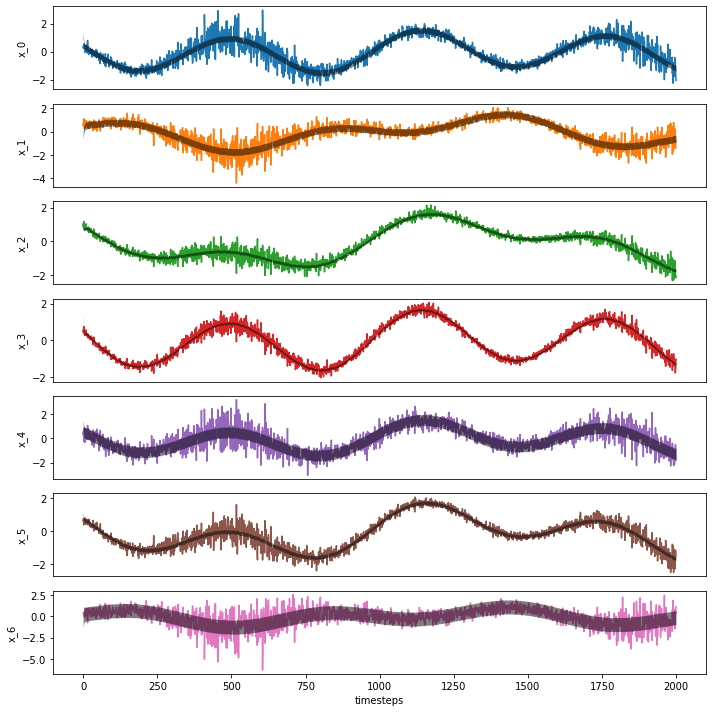

In [56]:
fig = plot_prediction(X_test, linear_model, figsize=(10,10))

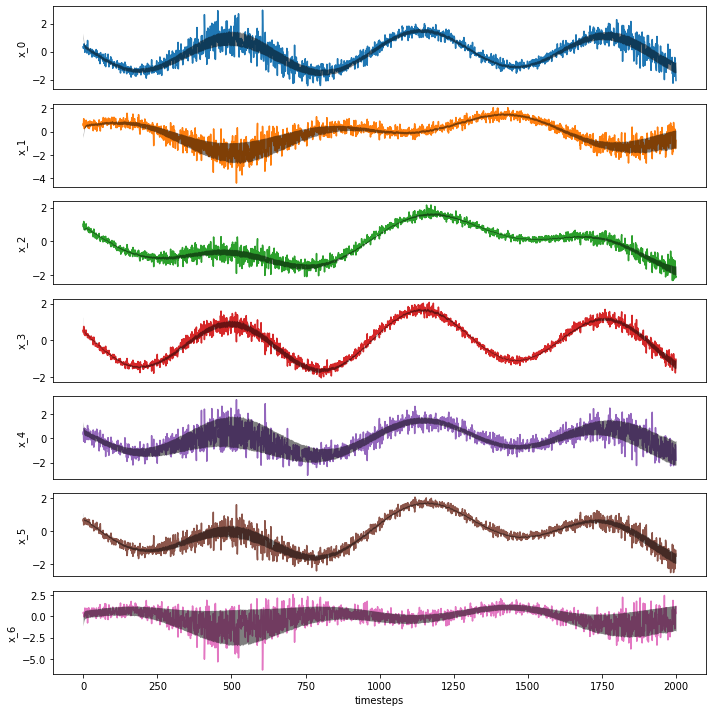

In [60]:
fig = plot_prediction(X_test, hs_model, figsize=(10,10))

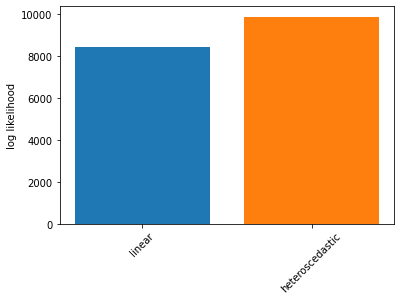

In [58]:
fig = plot_performance(X_test, [linear_model, hs_model], model_names=['linear', 'heteroscedastic'])